# **Overfitting and Model Selection**
## ECE 204 Data Science & Engineering

This notebook will show:

* the process of creating train/test/validation sets
* an example of overfitting
* an example of estimator complexity

## Input data

<Axes: xlabel='x0', ylabel='x1'>

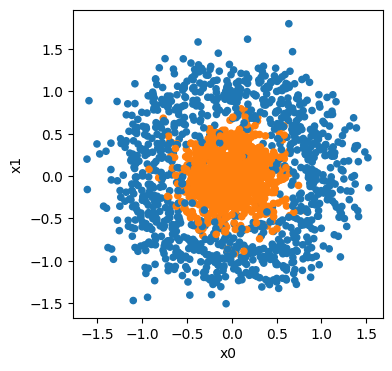

In [11]:
import pandas as pd

# this code creates the dataset

import sklearn.datasets as datasets
X, y = datasets.make_circles(n_samples=2000, factor=0.2, noise=0.24, random_state=42)
# X, y = datasets.make_blobs(n_samples=2000, cluster_std=1.0, random_state=42)  # another dataset to try
# X, y = datasets.make_moons(n_samples=2000, noise=0.3, random_state=42)  # another dataset to try

# put the data into a dataframe and make a scatter plot.

df = pd.DataFrame({"x0": X[:,0], "x1": X[:,1], "y": y})
df.plot.scatter(x="x0", y="x1", c="y", cmap="tab10", vmax=10, colorbar=False, figsize=(4,4))

## Decision tree classifier

Let's make a simple decision tree classifier and see what we get. We begin by creating a test/train split.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=0)

Let's try a decision tree with a depth of 8 to see how it performs.

In [13]:
from sklearn.tree import DecisionTreeClassifier

max_depth = 8

clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

X_tr = pd.DataFrame({"x0": X_train[:,0], "x1": X_train[:,1]})
clf.fit(X_tr, y_train)

DecisionTreeClassifier(max_depth=8, random_state=42)

Let's visualize the decision region:

In [14]:
# This cell produces a uniform grid of points for visualization purposes.

import numpy as np
x0 = np.linspace(df["x0"].min(), df["x0"].max())
x1 = np.linspace(df["x1"].min(), df["x1"].max())
x0, x1 = np.meshgrid(x0, x1)
df_grid = pd.DataFrame({"x0": x0.flat[:], "x1": x1.flat[:]})

Text(0.5, 1.0, 'Classifier Boundaries')

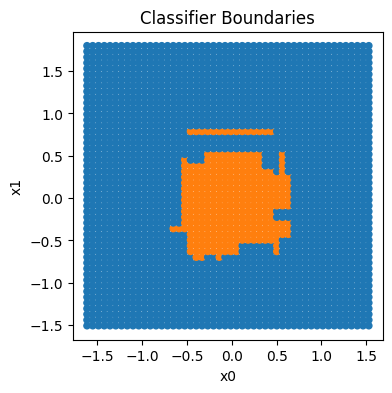

In [15]:
# create predictions on the test set and plot them.

y_pred = clf.predict(df_grid[["x0", "x1"]])
df_grid["pred"] = y_pred

ax = df_grid.plot.scatter(x="x0", y="x1", c="pred", cmap="tab10", vmax=10, colorbar=False, figsize=(4,4))
ax.set_title('Classifier Boundaries')

### Evaluate the accuracy of the classifier on test and training sets

**Note:** we can evaluate the accuracy using the `.score` method or using the `accuracy_score` function. Both do the exact same thing. For example, if we have trained our model `clf`, we can do:
```python
# first method
y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score
s1 = accuracy_score( y_pred, y_test )

# second method (equivalent!)
s2 = clf.score( X_test, y_test )
```

In [16]:
print( "accuracy on training set = ", clf.score( X_train, y_train ) )
print( "accuracy on test set = ",     clf.score( X_test,  y_test  ) )

accuracy on training set =  0.9677777777777777
accuracy on test set =  0.945


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Looks like the classifier is more accurate on the training set than on the test set. Does this mean we are overfitting? Let's try this again with different choices of `max_depth` so that we have a basis for comparison.

## Choosing `max_depth`

Let's choose the best `max_depth` by wraping the code used above into a function.

Let's write a function where
* input: the training set and a max depth.
* output: the training accuracy and validation accuracy using two different approaches:
  1. validation accuracy on a single random split of the data and
  2. validation accuracy using 5-fold cross-validation.

In [17]:
from sklearn.model_selection import cross_val_score

def tree_performance(X, y, depth, seed=None):
    
    ## FIRST METHOD: simple train/validation split
    
    # create train/validation split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    # train a classifier
    clf = DecisionTreeClassifier(max_depth=depth, random_state=seed)
    clf.fit(X_train, y_train)
 
    # compute the training and validation accuracies
    train_score = clf.score(X_train, y_train)
    val_score = clf.score(X_val, y_val)
    
    
    ## SECOND METHOD: cross-validation
    clfcv = DecisionTreeClassifier(max_depth=depth, random_state=seed)
    cv_scores = cross_val_score(clfcv, X, y, cv=5)
    
    return { "max_depth": depth,
             "train_accuracy": train_score,
             "val_accuracy": val_score,
             "cv_accuracy": cv_scores.mean() }

In [18]:
# test the function to see that it works
# Note that the "val_accuracy" varies wildly but the train and cv accuracies are relatively constant. Why?

tree_performance( X, y, 4, seed=None )

{'max_depth': 4,
 'train_accuracy': 0.943125,
 'val_accuracy': 0.92,
 'cv_accuracy': np.float64(0.933)}

### Create plot to compare different choices of `max_depth`

Let's call our function repeatedly with different tree depths to compare the relative accuracies of the models.

Text(0.5, 1.0, 'Classification Accuracy vs Maximum Tree Depth')

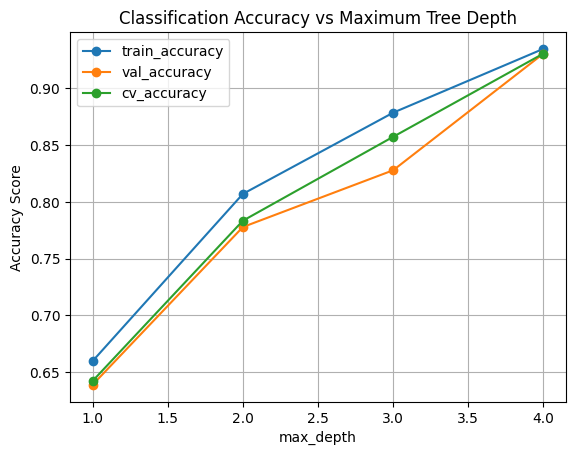

In [19]:
data = [ tree_performance(X_train, y_train, k, seed=None) for k in range(1,5) ]

df = pd.DataFrame(data)
ax = df.plot(x="max_depth", y=["train_accuracy","val_accuracy","cv_accuracy"], style="o-", grid=True)
ax.set_ylabel('Accuracy Score')
ax.set_title('Classification Accuracy vs Maximum Tree Depth')

Looks like `max_depth=4` is the best choice of depth. Let's train a model with `max_depth=4`, and test it to see the accuracy:

In [20]:
clf = DecisionTreeClassifier(max_depth=4)

seed = 42

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.95

In [1]:
import numpy as np

A = np.random.randint(1, 10, (2, 2))
B = np.random.randint(1, 10, (2, 2))

print("A:\n", A)
print("B:\n", B)
print("A @ B:\n", A @ B)
print("B @ A:\n", B @ A)

A:
 [[2 8]
 [8 6]]
B:
 [[1 6]
 [5 2]]
A @ B:
 [[42 28]
 [38 60]]
B @ A:
 [[50 44]
 [26 52]]


In [2]:
np.array([i + 3*j for i in range(3) for j in range(3)]).reshape(3,3)

array([[0, 3, 6],
       [1, 4, 7],
       [2, 5, 8]])

In [3]:
w = np.array([[0],[1],[2]])
np.block( [w+i for i in range(0,7,3)] )

array([[0, 3, 6],
       [1, 4, 7],
       [2, 5, 8]])